# Will my machine break down today?

## Introduction

In this notebook we use data of several machines to predict whether a component of a machine breaks down within the next hours. To do so, we will first evaluate the provided data, then we will try to understand the correlations between features for a single machine and finally we will select and train a suited machine learning model to achieve our goal.

### The dataset consists of the following data:

- Machine conditions and usage: The operating conditions of a machine e.g. data collected from sensors.  
- Failure history: The failure history of a machine or component within the machine.  
- Maintenance history: The repair history of a machine, e.g. error codes, previous maintenance activities or component replacements.  
- Machine features: The features of a machine, e.g. engine size, make and model, location.  

### Details
- Telemetry Time Series Data (PdM_telemetry.csv): It consists of hourly average of voltage, rotation, pressure, vibration collected from 100 machines for the year 2015.  

- Error (PdM_errors.csv): These are errors encountered by the machines while in operating condition. Since, these errors don't shut down the machines, these are not considered as failures. The error date and times are rounded to the closest hour since the telemetry data is collected at an hourly rate.  

- Maintenance (PdM_maint.csv): If a component of a machine is replaced, that is captured as a record in this table. Components are replaced under two situations: 1. During the regular scheduled visit, the technician replaced it (Proactive Maintenance) 2. A component breaks down and then the technician does an unscheduled maintenance to replace the component (Reactive Maintenance). This is considered as a failure and corresponding data is captured under Failures. Maintenance data has both 2014 and 2015 records. This data is rounded to the closest hour since the telemetry data is collected at an hourly rate.  

- Failures (PdM_failures.csv): Each record represents replacement of a component due to failure. This data is a subset of Maintenance data. This data is rounded to the closest hour since the telemetry data is collected at an hourly rate.  

- Metadata of Machines (PdM_Machines.csv): Model type & age of the Machines.  

### Acknowledgements
This dataset was available as a part of Azure AI Notebooks for Predictive Maintenance. But as of 15th Oct, 2020 the notebook (link) is no longer available. However, the data can still be downloaded using the following URLs:

https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_telemetry.csv  
https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_errors.csv  
https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_maint.csv  
https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_failures.csv  
https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_machines.csv  

### Get libraries and data

In [5]:
from utils import unzip_files
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [6]:
#Unzip files
input_path='data.zip'
output_path='data'
unzip_files(input_path,output_path)

# Exploratory Data Analysis

To get an idea of what kind of data is in front of us and to find any issues (missing data, wrong formatting, etc.) we will first have a look into the provided datasets without going too much into detail.

### Machine data

In [7]:
# Machine features
df_machines=pd.read_csv('data/PdM_machines.csv')
df_machines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   machineID  100 non-null    int64 
 1   model      100 non-null    object
 2   age        100 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.5+ KB


In [8]:
df_machines.describe(include='all')

,machineID,model,age
count,100.000000,100,100.000000
unique,NaN,4,NaN
top,NaN,model3,NaN
freq,NaN,35,NaN
mean,50.500000,NaN,11.330000
std,29.011492,NaN,5.856974
min,1.000000,NaN,0.000000
25%,25.750000,NaN,6.750000
50%,50.500000,NaN,12.000000
75%,75.250000,NaN,16.000000


In [9]:
# check if machineID is unique
df_machines.machineID.is_unique

True

<function matplotlib.pyplot.show(close=None, block=None)>

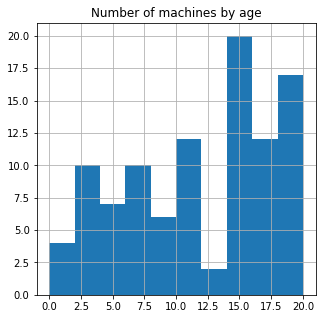

In [10]:
#Histogram: number of machines by age
df_machines.age.hist(bins=10, figsize=(5,5)).set_title('Number of machines by age')
plt.show

Text(0.5, 1.0, 'Number of machines by model')

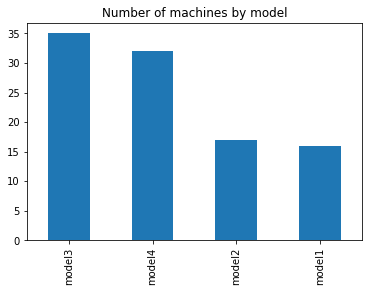

In [11]:
df_machines.model.value_counts().plot.bar().set_title('Number of machines by model')

Summary

- There are 100 machines of 4 different types (models)
- Most of the machines are of model 3 and 4
- The machines are between 0 and 20 years old
- No missing values
- All machine id's are unique

### Telemetry

In [12]:
# Telemetry
df_telemetry=pd.read_csv('data/PdM_telemetry.csv')
df_telemetry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876100 entries, 0 to 876099
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   876100 non-null  object 
 1   machineID  876100 non-null  int64  
 2   volt       876100 non-null  float64
 3   rotate     876100 non-null  float64
 4   pressure   876100 non-null  float64
 5   vibration  876100 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 40.1+ MB


In [15]:
#Last date in dataset
date_max=pd.to_datetime(df_telemetry.datetime).max()
date_max

Timestamp('2016-01-01 06:00:00')

In [16]:
#First date in dataset
date_min=pd.to_datetime(df_telemetry.datetime).min()
date_min

Timestamp('2015-01-01 06:00:00')

In [17]:
#check for missing dates
df_tel_date = df_telemetry
df_tel_date = df_tel_date.set_index('datetime')

df_tel_date.index = pd.to_datetime(df_tel_date.index)
df_tel_date

# dates which are NOT in the sequence are returned
print(pd.date_range(
  start=date_min, end=date_max).difference(df_tel_date.index))

DatetimeIndex([], dtype='datetime64[ns]', freq=None)


In [18]:
df_telemetry.describe()

,machineID,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,170.777736,446.605119,100.858668,40.385007
std,28.866087,15.509114,52.673886,11.048679,5.370361
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,25.750000,160.304927,412.305714,93.498181,36.777299
50%,50.500000,170.607338,447.558150,100.425559,40.237247
75%,75.250000,181.004493,482.176600,107.555231,43.784938
max,100.000000,255.124717,695.020984,185.951998,76.791072


<function matplotlib.pyplot.show(close=None, block=None)>

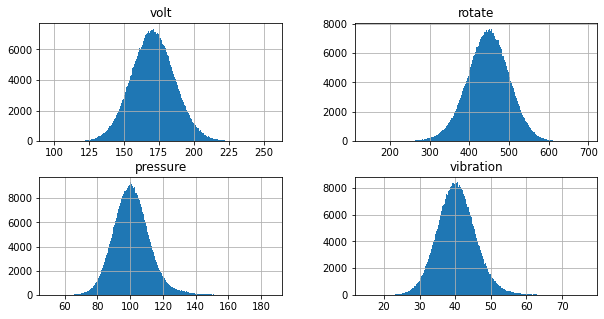

In [22]:
df_telemetry.drop('machineID',axis=1).hist(bins=500, figsize=(10,5))
plt.show

Summary

- Telemetry data of one year (2015)
- Values: voltage, rotation, pressure and vibration
- No missing values

### Errors

In [23]:
# Errors
df_errors=pd.read_csv('data/PdM_errors.csv')
df_errors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3919 entries, 0 to 3918
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   datetime   3919 non-null   object
 1   machineID  3919 non-null   int64 
 2   errorID    3919 non-null   object
dtypes: int64(1), object(2)
memory usage: 92.0+ KB


Text(0.5, 1.0, 'Number of errors by error id')

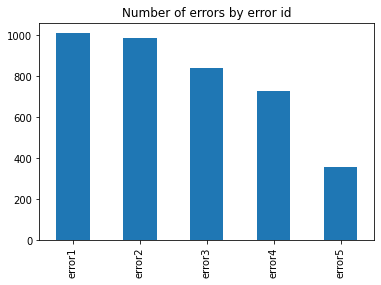

In [26]:
df_errors.errorID.value_counts().plot.bar().set_title('Number of errors by error id')

In [27]:
df_errors.datetime=pd.to_datetime(df_errors.datetime)
df_errors['date']=df_errors.datetime.dt.date
df_errors['month']=df_errors.datetime.dt.month

Text(0.5, 1.0, 'Errors per month')

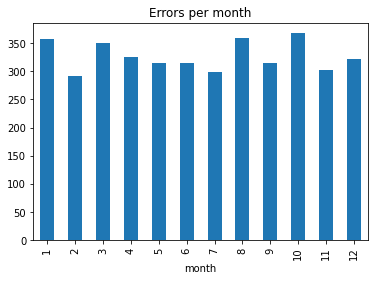

In [28]:
errors_per_month=df_errors.groupby([df_errors.month]).count()
errors_per_month.errorID.plot.bar().set_title('Errors per month')

Summary

- 5 different errors
- Errors are more or less equally divided over the year
- Attributes: voltage, rotation, pressure and vibration
- No missing values

### Failures

In [21]:
# Failures
df_failures=pd.read_csv('data/PdM_failures.csv')
df_failures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   datetime   761 non-null    object
 1   machineID  761 non-null    int64 
 2   failure    761 non-null    object
dtypes: int64(1), object(2)
memory usage: 18.0+ KB


In [22]:
df_failures.describe()

,machineID
count,761.000000
mean,51.911958
std,29.515542
min,1.000000
25%,24.000000
50%,51.000000
75%,79.000000
max,100.000000


Text(0.5, 1.0, 'Number of failures by component')

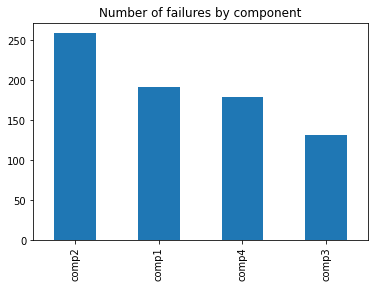

In [23]:
df_failures.failure.value_counts().plot.bar().set_title('Number of failures by component')

In [24]:
df_failures.datetime=pd.to_datetime(df_errors.datetime)
df_failures['date']=df_errors.datetime.dt.date
df_failures['month']=df_errors.datetime.dt.month

Text(0.5, 1.0, 'Number of failures per month')

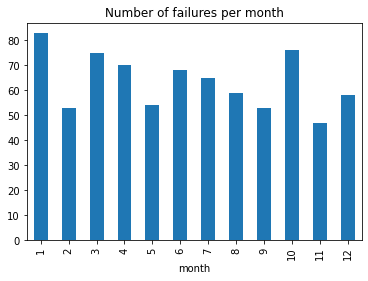

In [25]:
failure_per_month=df_failures.groupby([df_failures.month]).count()
failure_per_month.failure.plot.bar().set_title('Number of failures per month')

Summary

- 4 different different components failed certain times
- No missing values

### Maintenance

According to the dataset's description maintenance means replacement of a particular component.

In [26]:
# Maintenance
df_maint=pd.read_csv('data/PdM_maint.csv')
df_maint.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3286 entries, 0 to 3285
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   datetime   3286 non-null   object
 1   machineID  3286 non-null   int64 
 2   comp       3286 non-null   object
dtypes: int64(1), object(2)
memory usage: 77.1+ KB


In [27]:
df_maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [28]:
df_maint.datetime.min()

'2014-06-01 06:00:00'

In [29]:
df_maint.datetime.max()

'2016-01-01 06:00:00'

In [30]:
df_maint.datetime=pd.to_datetime(df_maint.datetime)
df_maint['date']=df_maint.datetime.dt.date
df_maint['month']=df_maint.datetime.dt.month

In [31]:
#types of maintenance
df_maint.comp.value_counts()

comp2    863
comp4    811
comp3    808
comp1    804
Name: comp, dtype: int64

Text(0.5, 1.0, 'Maintenance per month (total)')

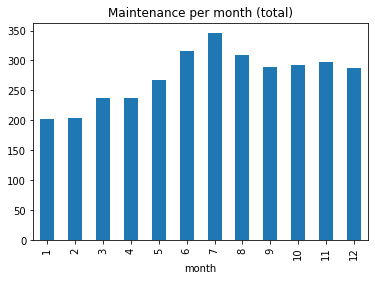

In [32]:
maint_per_month=df_maint.groupby([df_maint.month]).count()
maint_per_month.comp.plot(kind='bar', stacked='true').set_title('Maintenance per month (total)')

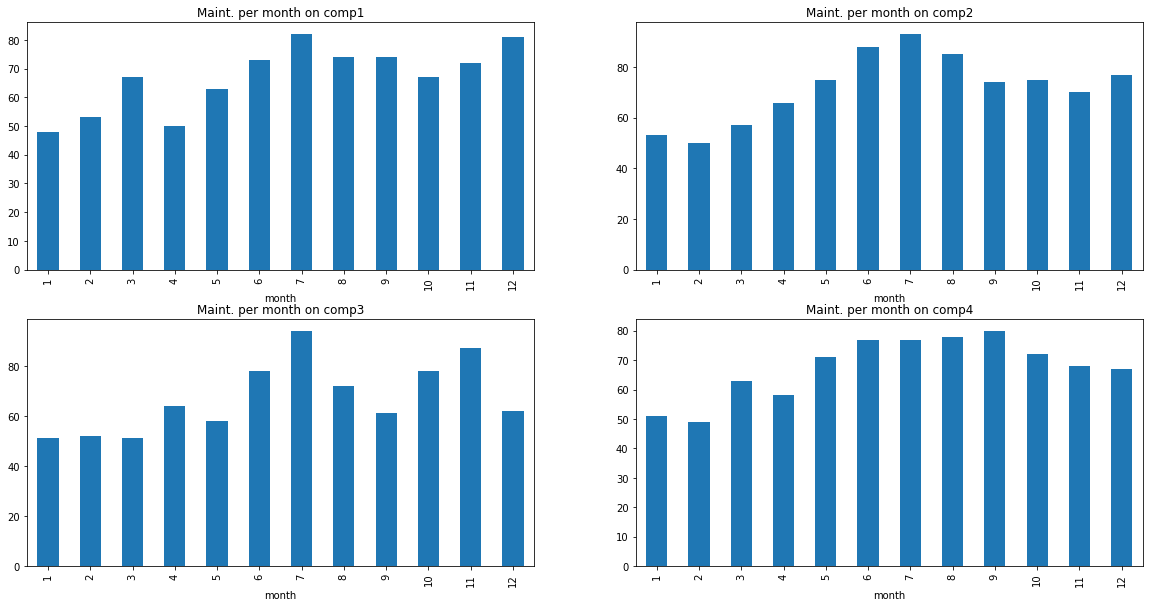

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=2)

ax_coord=[[0,0],[0,1],[1,0],[1,1]]

i=0
for c in df_maint.sort_values(by=['comp']).comp.unique():
    maint_c=df_maint[df_maint.comp==c]
    maint_c_per_month=maint_c.groupby([maint_c.month]).count()
    maint_c_per_month.comp.plot(kind='bar', stacked='true', figsize=(20,10), ax=axes[ax_coord[i][0],ax_coord[i][1]]).set_title('Maint. per month on '+c)
    i+=1
    
plt.show()

Summary
- Maintenance data of 2 years
- No missing values

## Looking into data of a single machine

Our goal is to create a ml-model that is able to predict whether amachine will fail within a certain ime frame. Before we put the data into several models let's first have a look into the data of a single machine. This might help us to find and understand correlations between the features visually.


In [34]:
#select a machine
mach=df_machines.iloc[4]
mach

machineID         5
model        model3
age               2
Name: 4, dtype: object

In [35]:
#get telemetry, errors, failures and maintenance data of this machine
df_mach_tele=df_telemetry.loc[df_telemetry.machineID==mach.machineID]
df_mach_fail=df_failures.loc[df_failures.machineID==mach.machineID]

It would be nice to know if errors or failures have a timely correlation with sensor data (such as "a component is usually running into a failure after the sensor data shows particular measurements).
  
For now, just out of curiousity, we will visualise the sensor data around the occurence of a randomly picked failure.  
  
Therefore we will merge telemetry data and failure data by date.

In [36]:
#convert datetime object to datetime64 
df_mach_tele.datetime=pd.to_datetime(df_mach_tele.datetime)
df_mach_fail.datetime=pd.to_datetime(df_mach_fail.datetime)

df_tele_fail=df_mach_tele.merge(df_mach_fail, how='left', on='datetime')

df_mach_fail

/var/folders/3_/y4jn6p5x3mnbt1cs_ffs_fb80000gn/T/ipykernel_60214/2046554879.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mach_tele.datetime=pd.to_datetime(df_mach_tele.datetime)
/var/folders/3_/y4jn6p5x3mnbt1cs_ffs_fb80000gn/T/ipykernel_60214/2046554879.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mach_fail.datetime=pd.to_datetime(df_mach_fail.datetime)


,datetime,machineID,failure,date,month
22,2015-06-23 10:00:00,5,comp2,2015-06-23,6
23,2015-08-23 19:00:00,5,comp1,2015-08-23,8
24,2015-08-30 01:00:00,5,comp1,2015-08-30,8
25,2015-09-01 06:00:00,5,comp2,2015-09-01,9
26,2015-09-13 17:00:00,5,comp1,2015-09-13,9
27,2015-09-15 06:00:00,5,comp2,2015-09-15,9
28,2015-10-01 23:00:00,5,comp1,2015-10-01,10


All failures are stored in the same column. For easier handling we will split the data into one column per component (one-hot-encoding)

In [37]:
df_mach_fail

,datetime,machineID,failure,date,month
22,2015-06-23 10:00:00,5,comp2,2015-06-23,6
23,2015-08-23 19:00:00,5,comp1,2015-08-23,8
24,2015-08-30 01:00:00,5,comp1,2015-08-30,8
25,2015-09-01 06:00:00,5,comp2,2015-09-01,9
26,2015-09-13 17:00:00,5,comp1,2015-09-13,9
27,2015-09-15 06:00:00,5,comp2,2015-09-15,9
28,2015-10-01 23:00:00,5,comp1,2015-10-01,10


In [38]:
df_tele_fail = pd.get_dummies(df_tele_fail,prefix=['f'], columns = ['failure'])
df_tele_fail

,datetime,machineID_x,volt,rotate,pressure,vibration,machineID_y,date,month,f_comp1,f_comp2
0,2015-01-01 06:00:00,5,165.082899,452.283576,84.591722,40.298803,NaN,NaN,NaN,0,0
1,2015-01-01 07:00:00,5,192.783995,515.389673,119.082137,37.302359,NaN,NaN,NaN,0,0
2,2015-01-01 08:00:00,5,159.702056,512.294013,90.212540,44.295005,NaN,NaN,NaN,0,0
3,2015-01-01 09:00:00,5,162.706162,308.578855,95.072898,39.401406,NaN,NaN,NaN,0,0
4,2015-01-01 10:00:00,5,166.158350,521.153678,76.874388,41.023317,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...
8756,2016-01-01 02:00:00,5,162.964887,511.046527,153.187090,41.772148,NaN,NaN,NaN,0,0
8757,2016-01-01 03:00:00,5,136.402165,402.228972,152.191926,38.078241,NaN,NaN,NaN,0,0
8758,2016-01-01 04:00:00,5,181.426439,460.280665,142.451849,44.551477,NaN,NaN,NaN,0,0
8759,2016-01-01 05:00:00,5,178.261658,424.821800,156.228631,39.976910,NaN,NaN,NaN,0,0


<AxesSubplot:xlabel='[datetime]', ylabel='[f_comp2]'>

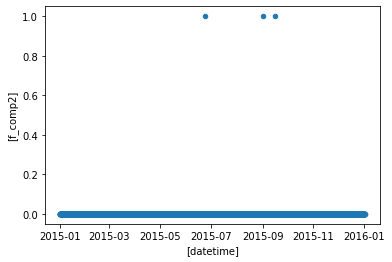

In [39]:
#Occurence of failure of component 2 over time
df_tele_fail.plot(kind='scatter', x=['datetime'], y=['f_comp2'])


Let's have a closer look into the sensor data around a timestamp when component 2 failed (e.g. 2015-09-15 06:00:00 --> id=6168)

<AxesSubplot:xlabel='datetime'>

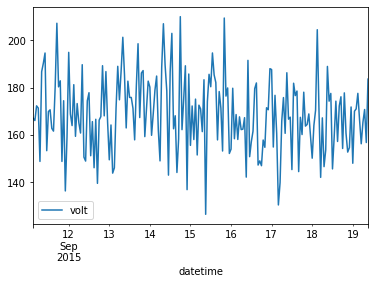

In [40]:
id=6168
threshold=100
df_tele_fail.loc[(df_tele_fail.index>id-threshold) & (df_tele_fail.index<id+threshold)].plot(x='datetime', y='volt')

Voltage does not show anomalities around the occurence of comp2-failure

<AxesSubplot:xlabel='datetime'>

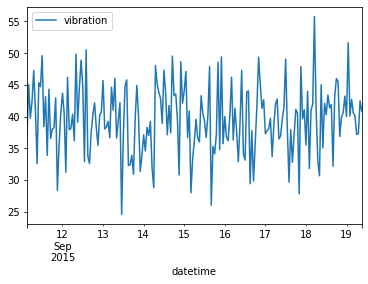

In [41]:
df_tele_fail.loc[(df_tele_fail.index>id-threshold) & (df_tele_fail.index<id+threshold)].plot(x='datetime', y='vibration')

Vibration does not show anomalities around the occurence of comp2-failure

<AxesSubplot:xlabel='datetime'>

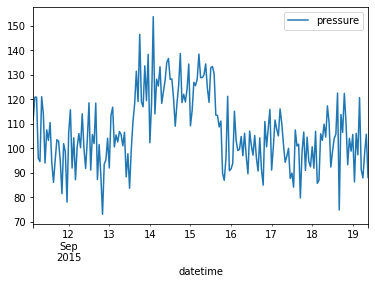

In [42]:
df_tele_fail.loc[(df_tele_fail.index>id-threshold) & (df_tele_fail.index<id+threshold)].plot(x='datetime', y='pressure')

Pressure is increased around the occurence of comp2-failure

**The example shows that there are anomalities in the features that might be useful for the ml-model.**

# Prepare Data for ML-Model

## Labeling the dataset for binary classification

Vom Moment eines Komponentenaustauschs werden die Messwerte der letzten n Zeiteinheiten als "Wartung" markiert


1. Loop through all machines
   1. Get telemetry data for the machine
   2. Get failure data for the machine
   3. One-Hote-Encode failures to get one column for each component
   4. Join telemetry and failure data
   5. Label rows with failures and n preceeding rows with '1', all other rows with '0'



In [43]:
#get fresh copies of the datasets
df_machines=pd.read_csv('data/PdM_machines.csv')
df_telemetry=pd.read_csv('data/PdM_telemetry.csv')
df_failures=pd.read_csv('data/PdM_failures.csv')

In [45]:
df_telemetry=df_telemetry.merge(df_machines, how='left', on='machineID')
df_telemetry=df_telemetry[df_telemetry.model=='model3']
df_telemetry=pd.get_dummies(df_telemetry,prefix=[''], prefix_sep=[''], columns = ['model'], drop_first=False)
df_telemetry

,datetime,machineID,volt,rotate,pressure,vibration,age,model3
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,18,1
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,18,1
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,18,1
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,18,1
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,18,1
...,...,...,...,...,...,...,...,...
814768,2016-01-01 02:00:00,93,202.858467,412.870855,85.569847,47.701614,18,1
814769,2016-01-01 03:00:00,93,171.364527,459.880473,94.316793,47.592136,18,1
814770,2016-01-01 04:00:00,93,182.867119,491.584480,90.332643,58.592710,18,1
814771,2016-01-01 05:00:00,93,166.943545,352.047138,82.068954,46.256361,18,1


In [46]:

def label_binary_clf(n, df, cols):
    """Label data for binary classification

    Args:
        n (int): Number of rows to be labeled before failure]
        df (dataframe): The dataframe containing features and label-columns
        cols (array): Label-columns

    Returns:
        dataframe: Dataframe containing the labeled data
    """
    df[cols]=df[cols].fillna(method="bfill", limit=n)
    return df

n=36
df_tele_fail_all=pd.DataFrame()
for index, row in df_machines.iterrows():
    df_tele=df_telemetry[df_telemetry.machineID==row.machineID]
    df_fail=df_failures[df_failures.machineID==row.machineID]
    components=df_fail.failure.unique()
    df_fail=pd.get_dummies(df_fail,prefix=[''], prefix_sep=[''], columns = ['failure'], drop_first=False)
    df_fail=df_fail.drop(columns=['machineID'])
    df_tele_fail=df_tele.merge(df_fail, how='left', on=['datetime'])
    df_tele_fail=label_binary_clf(n, df_tele_fail, components)
    df_tele_fail_all=pd.concat([df_tele_fail_all, df_tele_fail])

df_tele_fail_all=df_tele_fail_all.fillna(0)
df_tele_fail_all[df_tele_fail_all.comp1==1]


,datetime,machineID,volt,rotate,pressure,vibration,age,model3,comp1,comp2,comp4,comp3
1500,2015-03-04 18:00:00,1,186.260099,493.983905,104.296202,44.468203,18,1,1.0,0.0,0.0,0.0
1501,2015-03-04 19:00:00,1,171.671520,360.736832,101.886029,39.946633,18,1,1.0,0.0,0.0,0.0
1502,2015-03-04 20:00:00,1,188.911905,383.292730,102.418570,37.633302,18,1,1.0,0.0,0.0,0.0
1503,2015-03-04 21:00:00,1,210.473519,472.531431,112.533270,40.620846,18,1,1.0,0.0,0.0,0.0
1504,2015-03-04 22:00:00,1,183.137035,441.870156,92.064710,34.676932,18,1,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4316,2015-06-30 02:00:00,93,166.558001,361.714360,106.230878,28.112000,18,1,1.0,0.0,0.0,0.0
4317,2015-06-30 03:00:00,93,198.768217,418.984082,113.047134,41.101965,18,1,1.0,0.0,0.0,0.0
4318,2015-06-30 04:00:00,93,193.018032,327.290927,111.788164,40.410020,18,1,1.0,0.0,0.0,0.0
4319,2015-06-30 05:00:00,93,193.299245,408.886948,118.608602,45.337151,18,1,1.0,0.0,0.0,0.0


## Create Training-Set and Test-Set

In [47]:
df_ma=df_tele_fail_all #[df_tele_fail_all.machineID==1]
df_ma['pressure_ma']=df_ma['pressure'].rolling(window=1000).mean()
df_ma['vibration_ma']=df_ma['vibration'].rolling(window=1000).mean()
df_ma['volt_ma']=df_ma['volt'].rolling(window=1000).mean()
df_ma['rotate_ma']=df_ma['rotate'].rolling(window=1000).mean()
df_ma=df_ma.dropna()
#df_ma.info()

In [48]:
#X1=df_ma[['volt','rotate','vibration','pressure','model1','model2','model3','model4','age']].values
X1=df_ma[['volt','rotate','vibration','pressure','age']].values

y_comp1=df_ma['comp2'].values


X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y_comp1, test_size=0.1, random_state=42)
#X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y_comp4, test_size=0.1, random_state=42)
#X_train, X_test, y_train_2, y_test_2 = train_test_split(X, y_comp2, test_size=0.1, random_state=42)
#X_train, X_test, y_train_3, y_test_3 = train_test_split(X, y_comp3, test_size=0.1, random_state=42)
#X_train, X_test, y_train_4, y_test_4 = train_test_split(X, y_comp4, test_size=0.1, random_state=42)

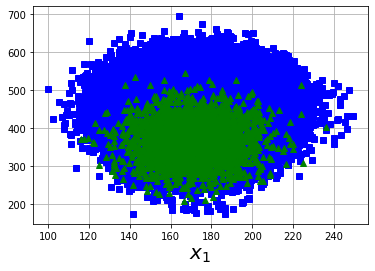

In [49]:
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    #plt.plot(X[:, 0][y==0],  "bs")
    #plt.plot(X[:, 0][y==1], "g^")


    #plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    #plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_dataset(X_train1, y_train1, [0,120,20,200])
plt.show()
#plot_dataset(X_train2, y_train2, [150,300,150,700])
#plt.show()

In [50]:
comp1_clf= Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='rbf',C=1, gamma=100))
])
comp1_clf.fit(X_train1,y_train1)

array([[6918,    0],
       [   6,   61]])

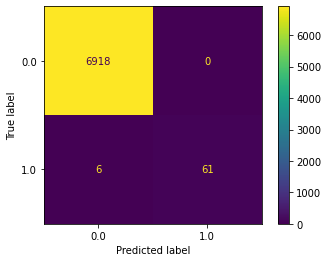

In [246]:
predictions = comp1_clf.predict(X_train1)
cm = confusion_matrix(y_train1, predictions, labels=comp1_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=comp1_clf.classes_)
disp.plot()

#plt.show()
cm